In [1]:
!nvidia-smi
import sys
sys.path.append('../../')
import jax
import jax.numpy as np
import os
# from cfd_am import *
from jax_am.cfd.cfd_am import *
from jax_am.cfd.json_parser import cfd_parse
from jax_am.cfd.generate_mesh import box_mesh
import time
os.environ["CUDA_VISIBLE_DEVICES"]="3"
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
%matplotlib notebook

Tue Nov 15 13:51:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:01:00.0 Off |                  Off |
| 31%   52C    P8    35W / 300W |  43901MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    Off  | 00000000:2E:00.0 Off |                  Off |
| 35%   

In [ ]:
crt_file_path = './ambench/'
data_dir = os.path.join(crt_file_path, 'data')

domain_x = 4.e-3
domain_y = 1.e-3
domain_z = 5.e-4
Nx = 400
Ny = 100 
Nz = 100 

cfd_args = cfd_parse(os.path.join(crt_file_path, 'cfd_params.json'))

mesh = mesh3d([domain_x, domain_y, domain_z], [Nx, Ny, Nz])
Nx_local = round((domain_x-cfd_args['X0'][0])/domain_x*Nx)
Ny_local = round(0.3*domain_y/domain_y*Ny)
Nz_local = round(0.4*domain_z/domain_z*Nz)

mesh_local = mesh3d([Nx_local/Nx*domain_x,Ny_local/Ny*domain_y,Nz_local/Nz*domain_z], 
                    [Nx_local,Ny_local,Nz_local])

# mesh_local = mesh

meshio_mesh = box_mesh(Nx, Ny, Nz, domain_x, domain_y, domain_z)


cfd_args['mesh'] = mesh
cfd_args['mesh_local'] = mesh_local
cfd_args['meshio_mesh'] = meshio_mesh
cfd_args['cp'] = lambda T: 0.2441*np.clip(T,300,1609)+338.59
cfd_args['latent_heat'] = 0.
cfd_args['k'] = lambda T: 0.016315*np.clip(T,300,1563)+4.5847
cfd_args['heat_source'] = 0
cfd_args['data_dir'] = data_dir


example = AM_3d(cfd_args)

{
    "rho": 8170,
    "visco": 0.007,
    "Marangoni": -0.0001,
    "dt": 1e-06,
    "t_OFF": 0.00208333,
    "speed": 0.96,
    "X0": [
        0.0005,
        0.0002,
        0.0004
    ],
    "rb": 3.35e-05,
    "eta": 0.45,
    "P": 285,
    "T_ref": 300,
    "Ts": 1533,
    "Tl": 1609,
    "write_sol_interval": 20,
    "check_sol_interval": 5
}


In [ ]:
# T = []

start_time = time.time()
for i in range(0,300):
    example.time_integration()
#     T.append(example.T0[150, 50, -1])
    elapsed = time.time() - start_time

    print(
        f'time:{elapsed},T_max:{example.T0.max()},vmax:{np.linalg.norm(example.vel0,axis=3).max()},pmax:{example.p0.max()}'
    )

    start_time = time.time()

<IPython.core.display.Javascript object>


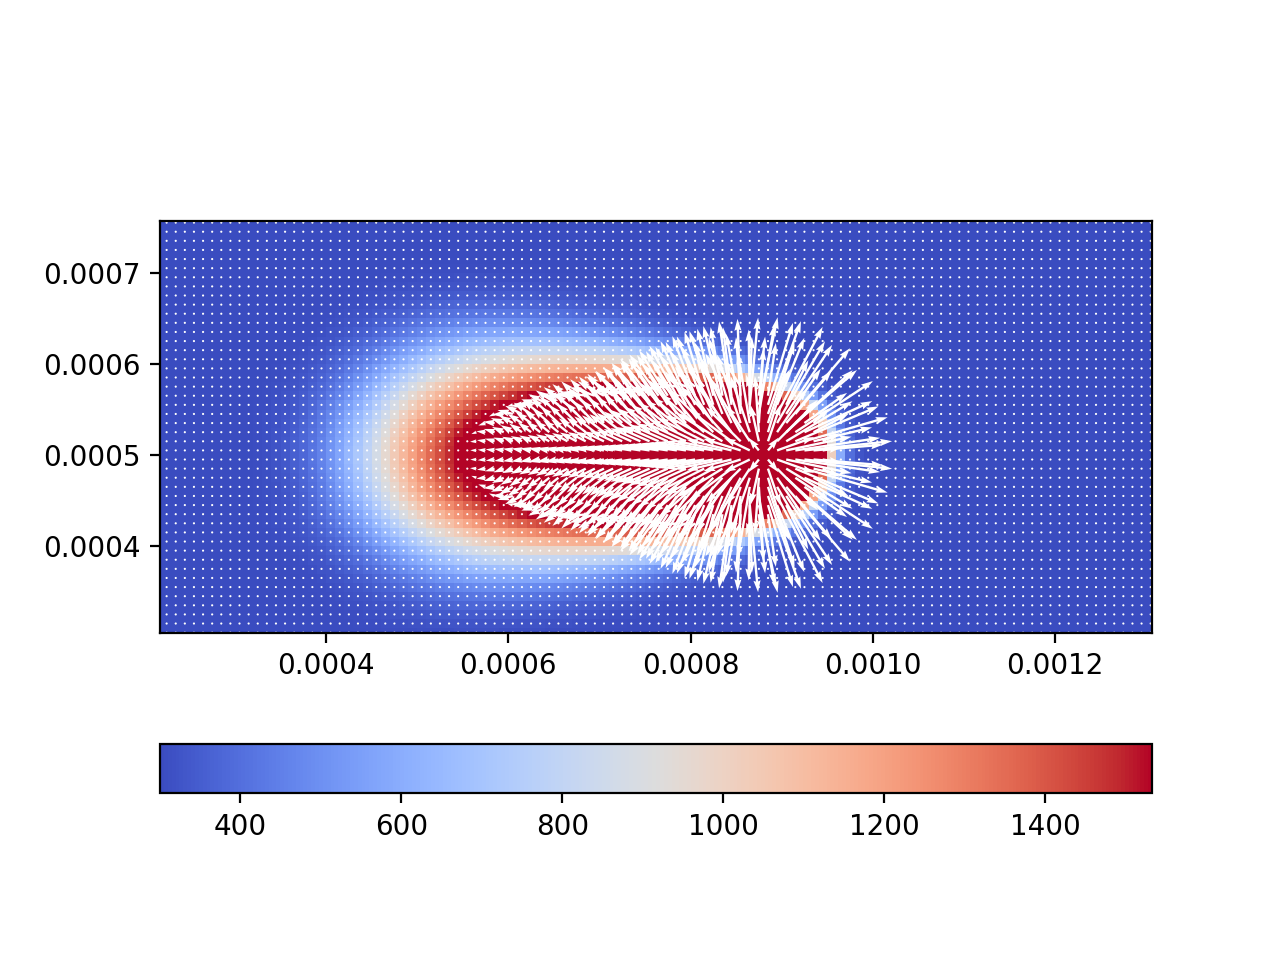

In [7]:
plt.figure()

pcm = plt.imshow(example.T0[:, :, -1].T,
                 origin='lower',
                 cmap='coolwarm',
                 vmax=1533,
                 extent=[0., domain_x, 0., domain_y])

u = example.vel0[:, :, -1, 0].flatten()
v = example.vel0[:, :, -1, 1].flatten()
xinterval = 1
yinterval = 1
plt.quiver(mesh.surface[mesh.surf_sets[-1]][:,0],
           mesh.surface[mesh.surf_sets[-1]][:,1],
           u,
           v,
           color='white',
           scale=10)
plt.colorbar(pcm, orientation='horizontal')


<IPython.core.display.Javascript object>


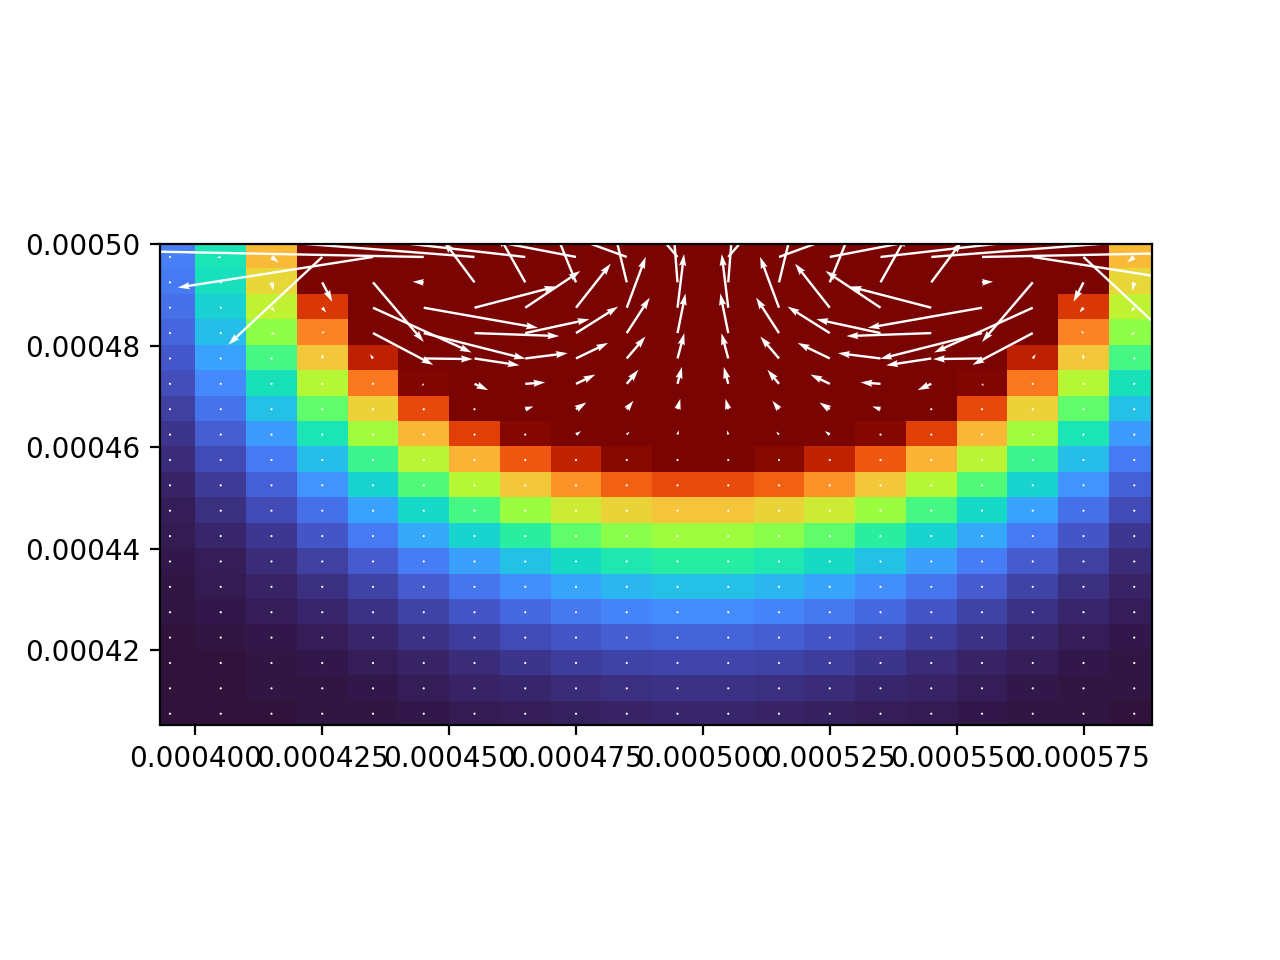

In [10]:
+

In [ ]:
xl = 115
plt.figure()
pcm = plt.imshow(example.T0[xl, :, :].T,
                 origin='lower',
                 cmap='turbo',
                 vmax=1563,
                 extent=[0., domain_y, 0., domain_z])


v = example.vel0[xl, :, :, 1].flatten()
w = example.vel0[xl, :, :, 2].flatten()
plt.quiver(mesh.surface[mesh.surf_sets[0]][:,1],
           mesh.surface[mesh.surf_sets[0]][:,2],
           v,
           w,
           color='white',
           scale=3)